In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20.0, 16.0)
import numpy as np
import cv2
import os
from tensorboardX import SummaryWriter

In [2]:
device = torch.device("cuda:0")

In [3]:
torch.cuda.is_available()

True

In [4]:
def readImg(path):
    
    I = cv2.imread(path)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = I[:256, :256, :]
    I = np.transpose(I, (-1, 0, 1))/127.5-1
    
    return I

def dataloader(path, batch_size = 32, isTest = False):
    X1, X2, y = [], [], []
#     random_list = np.random.randint(1, 8000, size=batch_size)
    random_list = np.arange(1, batch_size+1)
    if isTest:
        random_list = np.random.randint(8001, 10000, size=batch_size)
    for i in random_list:
        try:
            xx1 = readImg(os.path.join(path, "{:05d}_1.jpeg".format(i)))
            xx2 = readImg(os.path.join(path, "{:05d}_2.jpeg".format(i)))
            yy = readImg(os.path.join(path, "{:05d}_0.jpeg".format(i)))
        except:
            print("errneous idx: ", i)
        y.append(torch.Tensor(yy))
        X1.append(torch.Tensor(xx1))
        X2.append(torch.Tensor(xx2))
    X1 = torch.stack(X1)
    X2 = torch.stack(X2)
    y = torch.stack(y)
    return (X1, X2), y

In [5]:
class retina(object):
    def foveate(self, x, lc, isIt = True):
        ## camera model
        B, C, H, W = x.shape
        coors = (0.5 * ((lc + 1.0) * H)).long()
        defocus_imgs = []
        for i in range(B):
            im = (x[i].cpu()+1)/2
            im = np.transpose(im.numpy(), (1, 2, 0))
            im = self.looknext(im, coors[i], isIt = isIt)
            im = np.transpose(im, (-1, 0, 1))
            im = torch.from_numpy(im).unsqueeze(dim=0)
            defocus_imgs.append(im*2-1)
        defocus_imgs = torch.cat(defocus_imgs).to(device)
        return defocus_imgs
    
    def looknext(self, I, coor, rad = 50, gaussKernelSize = 15, isIt = True):
#         print("I shape: ", I.shape)
#         print("coor shape: ", coor.shape)
        
        x_c, y_c = coor[0], coor[1]

        blurred_img = cv2.GaussianBlur(I, (gaussKernelSize, gaussKernelSize), 0)

        mask = np.zeros(I.shape, dtype=np.uint8)
        if isIt==False:
            rad *=2
        mask = cv2.circle(mask, (x_c, y_c), rad, (255,255,255), -1)
        if isIt:
            out = np.where(mask==np.array([255, 255, 255]), I, blurred_img)
        else:
            out = np.where(mask!=np.array([255, 255, 255]), I, blurred_img)
        return out

In [6]:
class encoder(nn.Module):
    
    def __init__(self):
        super(encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 64, 5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 5, stride=4, padding=2)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        return x        

In [7]:
class decoder(nn.Module):
   
    def __init__(self):
        super(decoder, self).__init__()
            
        self.deconv4 = nn.ConvTranspose2d(256, 64, 4, stride=4)
        self.deconv5 = nn.ConvTranspose2d(64, 16, 4, stride=4)
        self.conv6 = nn.Conv2d(16, 1, 5, padding=2)        
  
    def forward(self, x):
        x = F.relu(self.deconv4(x))
        x = F.relu(self.deconv5(x))
        x = torch.tanh(self.conv6(x))
        x = (x+1)/2
        return x 

In [8]:
class mfnet(nn.Module):
    
    def __init__(self):
        super(mfnet, self).__init__()
        
        self._encoder = encoder()
        self._decoder = decoder()
        
    def forward(self, X1, X2, rtrn_feature = False):
        x1 = self._encoder(X1)
        x2 = self._encoder(X2)
        x = torch.cat((x1, x2), 1)
        x = self._decoder(x)
        if rtrn_feature:
            return x
        x = x.repeat(1, 3, 1, 1)
        x = x * X1 + (1 - x) * X2
        return x

In [9]:
class locnet(nn.Module):
    
    def __init__(self):
        super(locnet, self).__init__()

        self.conv7 = nn.Conv2d(3, 16, 8, stride=8)
        self.conv8 = nn.Conv2d(16, 32, 8, stride=8)
        self.fc = nn.Linear(4*4*32, 2)
    
    def forward(self, x):
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = x.view(-1, 4*4*32)
        mu = torch.tanh(self.fc(x))
        
        noise = torch.zeros_like(mu)
        noise.data.normal_(std=0.17)
        l_t = mu + noise

        # bound between [-1, 1]
        l_t = torch.tanh(l_t)
        return mu, l_t

In [10]:
class baselinenet(nn.Module):

    def __init__(self):
        super(baselinenet, self).__init__()
        self.conv9 = nn.Conv2d(3, 16, 8, stride=8)
        self.conv10 = nn.Conv2d(16, 32, 8, stride=8)
        self.fc2 = nn.Linear(4*4*32, 1)
    
    def forward(self, x):
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = x.view(-1, 4*4*32)
        b = self.fc2(x)
        
        return b

In [11]:
class roboticsnet(nn.Module):
    
    def __init__(self):
        super(roboticsnet, self).__init__()
        self._retina = retina()
        self._mfnet = mfnet()
        self._locnet = locnet()
        self._baselinenet = baselinenet()
        
    def forward(self, x, J_prev, l_prev):
        
        X1 = self._retina.foveate(x, l_prev, isIt = True)
        X2 = J_prev
        
        J = self._mfnet(X1, X2)
        mu,l = self._locnet(J)
        b = self._baselinenet(J).squeeze()
        log_pi = torch.distributions.Normal(mu, 0.17).log_prob(l)
        log_pi = torch.sum(log_pi, dim=1)
        
        return J, l, b, log_pi

In [12]:
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

In [13]:
model = roboticsnet().to(device)
print(model)
print(get_parameter_number(model))

roboticsnet(
  (_mfnet): mfnet(
    (_encoder): encoder(
      (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    )
    (_decoder): decoder(
      (deconv4): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(4, 4))
      (deconv5): ConvTranspose2d(64, 16, kernel_size=(4, 4), stride=(4, 4))
      (conv6): Conv2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (_locnet): locnet(
    (conv7): Conv2d(3, 16, kernel_size=(8, 8), stride=(8, 8))
    (conv8): Conv2d(16, 32, kernel_size=(8, 8), stride=(8, 8))
    (fc): Linear(in_features=512, out_features=2, bias=True)
  )
  (_baselinenet): baselinenet(
    (conv9): Conv2d(3, 16, kernel_size=(8, 8), stride=(8, 8))
    (conv10): Conv2d(16, 32, kernel_size=(8, 8), stride=(8, 8))
    (fc2): Linear(in_features=512, out_features=1, bias=Tr

In [14]:
checkpoint = torch.load("ckpt/model_ckpt.pth")

model._mfnet.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
print(list(model._mfnet.parameters())[1])

Parameter containing:
tensor([ 0.0018,  0.1038, -0.0042, -0.0027, -0.0191, -0.0700, -0.3516,  0.1091,
        -0.1582,  0.0110,  0.1276,  0.0568,  0.2201, -0.0012,  0.0005,  0.0027],
       device='cuda:0', requires_grad=True)


In [16]:
def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)
dfs_freeze(model._mfnet)

In [17]:
print(list(model._mfnet.parameters())[1])

Parameter containing:
tensor([ 0.0018,  0.1038, -0.0042, -0.0027, -0.0191, -0.0700, -0.3516,  0.1091,
        -0.1582,  0.0110,  0.1276,  0.0568,  0.2201, -0.0012,  0.0005,  0.0027],
       device='cuda:0')


In [18]:
print(model)
print(get_parameter_number(model))

roboticsnet(
  (_mfnet): mfnet(
    (_encoder): encoder(
      (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    )
    (_decoder): decoder(
      (deconv4): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(4, 4))
      (deconv5): ConvTranspose2d(64, 16, kernel_size=(4, 4), stride=(4, 4))
      (conv6): Conv2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (_locnet): locnet(
    (conv7): Conv2d(3, 16, kernel_size=(8, 8), stride=(8, 8))
    (conv8): Conv2d(16, 32, kernel_size=(8, 8), stride=(8, 8))
    (fc): Linear(in_features=512, out_features=2, bias=True)
  )
  (_baselinenet): baselinenet(
    (conv9): Conv2d(3, 16, kernel_size=(8, 8), stride=(8, 8))
    (conv10): Conv2d(16, 32, kernel_size=(8, 8), stride=(8, 8))
    (fc2): Linear(in_features=512, out_features=1, bias=Tr

In [19]:
# criterion = nn.MSELoss()
# optimizer_loc = optim.Adam(model._locnet.parameters(), lr = 0.0005)
# optimizer_baseline = optim.Adam(model._baselinenet.parameters(), lr = 0.0005)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)


In [20]:
# baselines = []
# log_pi = []
# (X1, X2), y = dataloader('../datasets/highres_dataset2/', batch_size=8)
# l = torch.rand(8, 2)*2-1

# X1, X2, y, l = X1.to(device), X2.to(device), y.to(device), l.to(device)

# # optimizer_loc.zero_grad()
# # optimizer_baseline.zero_grad()
# optimizer.zero_grad()
# J, l, b, p = model(y, X1, l)
# # print("J.shape: ", J.shape)
# # print("l.shape: ", l.shape)
# # print("b.shape: ", b.shape)
# # print("p.shape: ", p.shape)
# baselines.append(b)
# log_pi.append(p)
# baselines = torch.stack(baselines).transpose(1, 0)
# log_pi = torch.stack(log_pi).transpose(1, 0)
# # print("baselines.shape: ", baselines.shape)
# # print("log_pi.shape: ", log_pi.shape)

In [21]:
# ## one epoch training.
# R = -(J - y).pow(2).mean(dim = (1, 2, 3))
# R = R.unsqueeze(1)
# loss_baseline = F.mse_loss(baselines, R)
# adjusted_reward = R - baselines.detach()
# loss_reinforce = torch.sum(-log_pi*adjusted_reward, dim=1)
# loss_reinforce = torch.mean(loss_reinforce, dim=0)
# loss = loss_baseline+loss_reinforce
# loss.backward()
# print(loss_baseline.item())
# print(loss_reinforce.item())
# print(F.mse_loss(J, y).item())
# # optimizer_loc.step()
# # optimizer_baseline.step()
# optimizer.step()

In [22]:
(X1, X2), y = dataloader('../datasets/highres_dataset2/')
foveate_fun = retina().foveate
l_J = torch.rand(32, 2)*2-1
J_prev = foveate_fun(y, l_J, isIt = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


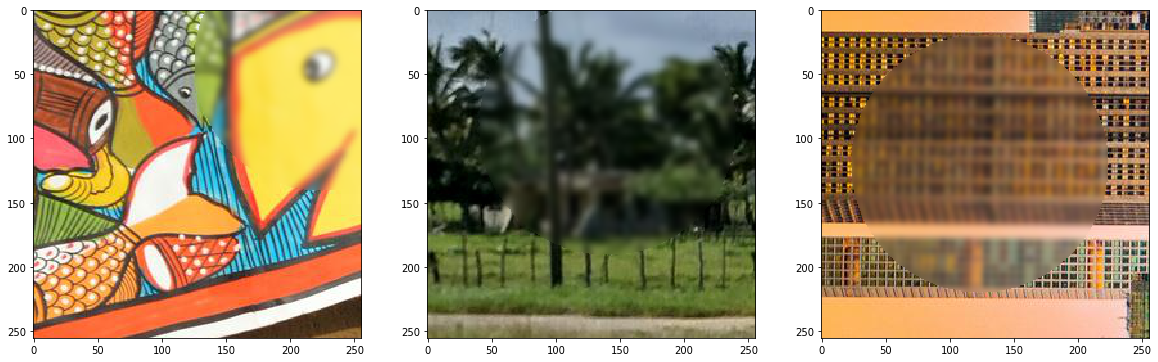

In [33]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(np.transpose(J_prev[3].cpu().numpy(), (1, 2, 0))/2+0.5)
ax[1].imshow(np.transpose(J_prev[4].cpu().numpy(), (1, 2, 0))/2+0.5)
ax[2].imshow(np.transpose(J_prev[5].cpu().numpy(), (1, 2, 0))/2+0.5)

In [29]:
print("===> training: ")
for epoch in range(1):

    for i in range(200):

        baselines = []
        log_pi = []
        l = torch.rand(32, 2)*2-1
        X1, X2, y, l = X1.to(device), X2.to(device), y.to(device), l.to(device)
        optimizer.zero_grad()
        J, l, b, p = model(y, J_prev, l)
        baselines.append(b)
        log_pi.append(p)
        
        J, l, b, p = model(y, J, l)
        baselines.append(b)
        log_pi.append(p)
        
        baselines = torch.stack(baselines).transpose(1, 0)
        log_pi = torch.stack(log_pi).transpose(1, 0)
        
        ## one epoch training.
        R = ((J_prev - y).pow(2).mean(dim = (1, 2, 3))-(J - y).pow(2).mean(dim = (1, 2, 3)))
        R = R.unsqueeze(1).repeat(1, 2)
        loss_baseline = 10*F.mse_loss(baselines, R)
        adjusted_reward = R - baselines.detach()
        loss_reinforce = torch.sum(-log_pi*adjusted_reward, dim=1)
        loss_reinforce = torch.mean(loss_reinforce, dim=0)
        loss = loss_baseline+loss_reinforce
        loss.backward()
        optimizer.step()
        
        if i % 20 == 19:
            print("i: {:d}, loss: {:.4f}, mse: {:.4f}".format(i, loss.item(), F.mse_loss(J_prev, y) - F.mse_loss(J, y).item()))
        

===> training: 
i: 19, loss: -0.0005, mse: 0.0023
i: 39, loss: -0.0001, mse: 0.0022
i: 59, loss: 0.0019, mse: 0.0023
i: 79, loss: 0.0003, mse: 0.0024
i: 99, loss: -0.0011, mse: 0.0027
i: 119, loss: 0.0004, mse: 0.0030
i: 139, loss: -0.0007, mse: 0.0023
i: 159, loss: 0.0002, mse: 0.0025
i: 179, loss: 0.0006, mse: 0.0024
i: 199, loss: 0.0007, mse: 0.0022


In [30]:
with torch.no_grad():
        X1, X2, y, l = X1.to(device), X2.to(device), y.to(device), l.to(device)
        l = torch.rand(32, 2)*2-1
        J, l_new, b, p = model(y, J_prev, l)

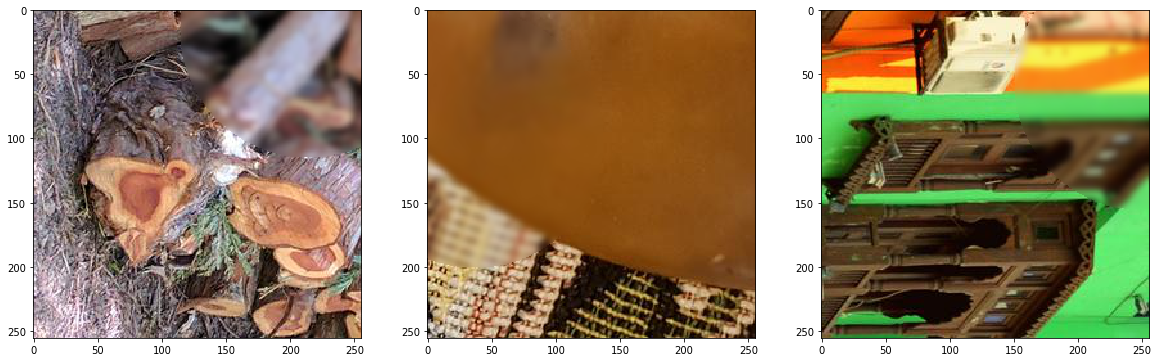

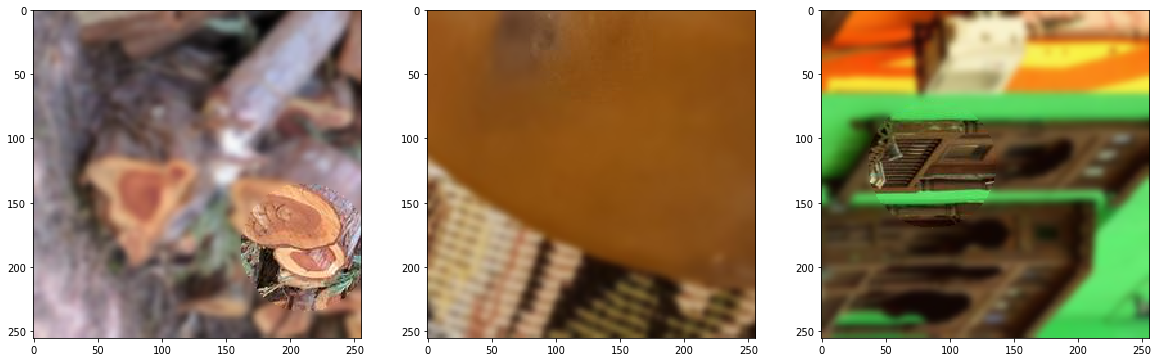

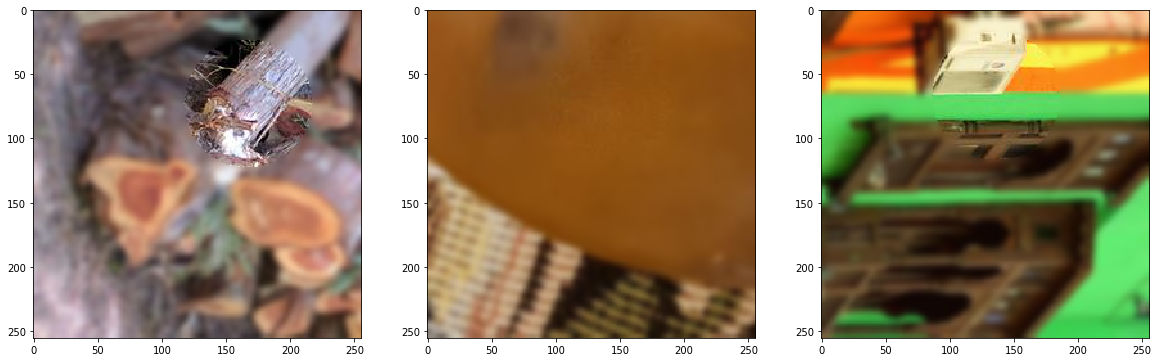

In [45]:
old_fov = foveate_fun(y, l, isIt = True)
new_fov = foveate_fun(y, l_new, isIt = True)

idx = 20

fig, ax = plt.subplots(1, 3)
ax[0].imshow(np.transpose(J_prev[idx].cpu().numpy(), (1, 2, 0))/2+0.5)
ax[1].imshow(np.transpose(J_prev[idx+1].cpu().numpy(), (1, 2, 0))/2+0.5)
ax[2].imshow(np.transpose(J_prev[idx+2].cpu().numpy(), (1, 2, 0))/2+0.5)
plt.show()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(np.transpose(old_fov[idx].cpu().numpy(), (1, 2, 0))/2+0.5)
ax[1].imshow(np.transpose(old_fov[idx+1].cpu().numpy(), (1, 2, 0))/2+0.5)
ax[2].imshow(np.transpose(old_fov[idx+2].cpu().numpy(), (1, 2, 0))/2+0.5)
plt.show()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(np.transpose(new_fov[idx].cpu().numpy(), (1, 2, 0))/2+0.5)
ax[1].imshow(np.transpose(new_fov[idx+1].cpu().numpy(), (1, 2, 0))/2+0.5)
ax[2].imshow(np.transpose(new_fov[idx+2].cpu().numpy(), (1, 2, 0))/2+0.5)
plt.show()


In [46]:
state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }
torch.save(state, "ckpt_rl/rl_model_ckpt.pth")

In [27]:
# with torch.no_grad():
#     (X1, X2), y = dataloader('../datasets/highres_dataset2/', isTest = True)
#     y_pred = model(X1.to(device), X2.to(device))
#     y_features = model(X1.to(device), X2.to(device), rtrn_feature = True)
    
# y_prediction = y_pred.cpu().numpy()
# y_prediction = np.transpose(y_prediction, (0, 2, 3, 1))
# y_f = y_features.cpu().numpy()
# y_f = np.transpose(y_f, (0, 2, 3, 1))
# y = np.transpose(y, (0, 2, 3, 1))
# X1 = np.transpose(X1, (0, 2, 3, 1))
# X2 = np.transpose(X2, (0, 2, 3, 1))

In [28]:
# idx = 7
# fig, ax = plt.subplots(1, 5)
# ax[0].imshow(y_prediction[idx]/2+0.5)
# ax[1].imshow(y[idx]/2+0.5)
# ax[2].imshow(y_f[idx, :, :, 0])
# ax[3].imshow(X1[idx]/2+0.5)
# ax[4].imshow(X2[idx]/2+0.5)